In [1]:
from scripts import mapcalc_kde
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt

In [2]:
arrests = pd.read_csv('Django_old/clean_data/arrests_GIS.csv')
schools = pd.read_csv('Django_old/clean_data/school_list_GIS.csv')
restaurants = pd.read_csv('Django_old/clean_data/restaurant_list_GIS.csv')
groceries = pd.read_csv('Django_old/clean_data/grocerystore_list_GIS.csv')
vacancies = pd.read_csv('Django_old/clean_data/vacancies_GIS.csv')

# filter out incorrectly geocoded locations in restaurants dataset
restaurants = restaurants[restaurants['Longitude'] < 0] 

bandwidth = 0.2
datasets = {
    'arrests':[arrests],
    'vacancies':[vacancies],
    'groceries':[groceries],
    'restaurants':[restaurants],
    'schools':[schools]
}

In [3]:
%matplotlib

Using matplotlib backend: MacOSX


Each dataset contains precise geospatial information in the form of latitude and longitude coordinates. When the dataset is sufficiently dense, a 2D plot of all points in the dataset provides a detailed map of the city. Sparse datasets, such as the locations of all public K-12 schools in the city, don't give as much detail.

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5))
ax1_x, ax1_y = datasets['arrests'][0]['Longitude'], datasets['arrests'][0]['Latitude']
ax1.plot(ax1_x, ax1_y, '.', color='red', alpha=0.1, label = 'Arrests')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
ax1.set_title('arrests')

ax2_x, ax2_y = datasets['schools'][0]['Longitude'], datasets['schools'][0]['Latitude']
ax2.plot(ax2_x, ax2_y, 'o', color='blue', label = 'schools')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
ax2.set_title('schools')

Rather than plotting the raw data, we can use a tool called kernel density estimation to represent the point density.

In [5]:
# compute kernel density estimates for all datasets using a Gaussian kernel with constant bandwidth
bandwidth = 0.3
for key in datasets:
    datasets[key].append(mapcalc_kde.compute_kde(
            datasets[key][0]['Longitude'], 
            datasets[key][0]['Latitude'], 
            bandwidth
        )
                        )

Now we can plot the density function for each individual map by computing the density at each point on a grid and then producing an image with the correct dimensions.

In [6]:
# Boundary conditions for all maps (longitudes as x vals, latitudes as y vals)
lonmin = -76.72
lonmax = -76.52
latmin = 39.19
latmax = 39.38

# number of points along each map edge
# (total number of points is npts**2)
npts = 50

x = np.linspace(lonmin, lonmax, npts)
y = np.linspace(latmin, latmax, npts)

X, Y = np.meshgrid(x, y, indexing='ij')
positions = np.vstack([X.ravel(), Y.ravel()])

# compute maps!
for key in datasets:
    datasets[key].append(mapcalc_kde.kde_map(x, y, datasets[key][1]))

In [7]:
# plot each map as an image
def plot_KDE(lons, lats, kernel_density, mapname, axn):
    axn.imshow(
        np.rot90(np.reshape(kernel_density, (len(lons), len(lats))).T),
        cmap=plt.cm.RdBu,
        extent=[min(lons), max(lons), min(lats), max(lats)]
    )
    axn.axis([min(lons), max(lons), min(lats), max(lats)])
    axn.set_title(mapname)
    axn.set_xlabel('Longitude')
    axn.set_ylabel('Latitude')

In [8]:
# Now we compute a recommendation map by penalizing crime and vacant lots and then
# adding all of the maps together
map_df = pd.DataFrame({
        'crime':-1*datasets['arrests'][-1], 
        'vacancy':-1*datasets['vacancies'][-1], 
        'grocery':datasets['groceries'][-1], 
        'restaurant':datasets['restaurants'][-1], 
        'schools':datasets['schools'][-1]
    })
ALL = rec_map = map_df.sum(axis=1).values

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,7))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
plot_KDE(x, y, datasets['arrests'][-1], 'arrests', ax1)
plot_KDE(x, y, datasets['vacancies'][-1], 'vacancies', ax2)
plot_KDE(x, y, datasets['schools'][-1], 'schools', ax3)
plot_KDE(x, y, datasets['groceries'][-1], 'groceries', ax4)
plot_KDE(x, y, datasets['restaurants'][-1], 'restaurants', ax5)
plot_KDE(x, y, ALL, 'ALL', ax6)

In [9]:
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
ax1_x, ax1_y = datasets['arrests'][0]['Longitude'], datasets['arrests'][0]['Latitude']
ax1.plot(ax1_x, ax1_y, '.', color='red', alpha=0.01, label = 'Arrests')
ax3.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('arrests')

ax2_x, ax2_y = datasets['schools'][0]['Longitude'], datasets['schools'][0]['Latitude']
ax2.plot(ax2_x, ax2_y, 'o', color='blue', label = 'schools')
ax2.set_title('schools')

plot_KDE(x, y, datasets['arrests'][-1], 'arrests', ax3)
plot_KDE(x, y, datasets['schools'][-1], 'schools', ax4)

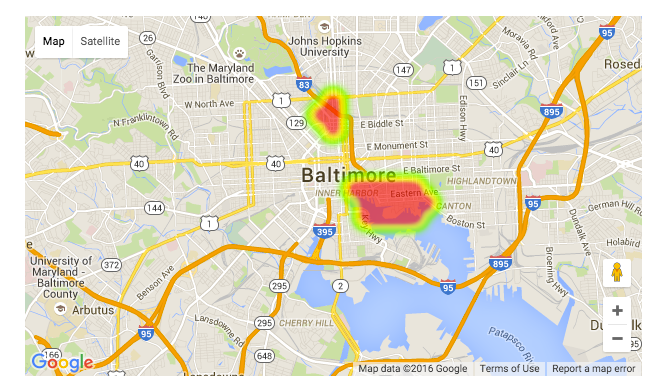

In [10]:
# The "recommendation" is the area of the map at which the density exceeds some user-defined threshhold.
# If we filter out all coordinates with densities below, say, the top 80th percentile, then send just those
# coordinates to google maps, we'd get a heatmap that looks like:
from IPython.display import Image 
PATH = "/Users/wallacdc/Dropbox/proposal/"
Image(filename = PATH + "ipython_notebooks/rec map.png", width=500)

NameError: name 'zc' is not defined

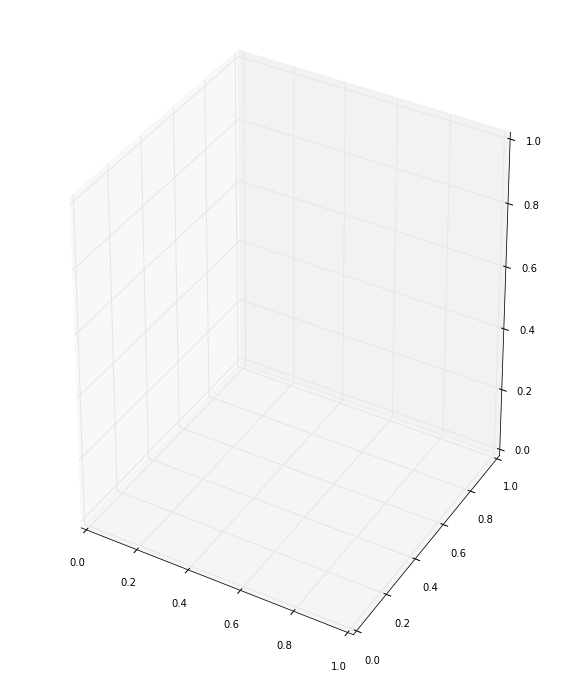

In [111]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,12))
#rcParams.update({'font.size': 14})
ax = fig.gca(projection='3d')

#zc = zone_cnts(0)
X = x
Y = y

x = 0.01
y = 0.025
b = 0.25
levels = linspace(b, 3, 45)

ax.contourf(X, Y, 0+x*Z1, zdir='z', levels=0+x*levels, alpha=0.2, nchunks=100) 
"""ax.contourf(X, Y, 0*Z1, zdir='z', levels=y*(levels-b), alpha=0.1, nchunks=100)
ax.contourf(X, Y, 1+x*Z1, zdir='z', levels=1+x*levels, alpha=0.2, lw=0)
ax.contourf(X, Y, 1+0*Z1, zdir='z', levels=1+y*(levels-b), alpha=0.1, nchunks=100)
ax.contourf(X, Y, 2+x*Z1, zdir='z', levels=2+x*levels, alpha=0.2, lw=0)
ax.contourf(X, Y, 2+0*Z1, zdir='z', levels=2+y*(levels-b), alpha=0.1, nchunks=100)
ax.contourf(X, Y, 4+x*Z1, zdir='z', levels=4+x*levels, alpha=0.2, lw=0)
ax.contourf(X, Y, 4+0*Z1, zdir='z', levels=4+y*(levels-b), alpha=0.1, nchunks=100)"""

ax.legend()
ax.set_xlim3d(min_lng, max_lng)
ax.set_ylim3d(min_lat, max_lat)
ax.set_zlim3d(0, 4)

ax.set_xticks(lng_bins)
ax.set_yticks(lat_bins)
ax.set_zticks([1,2,3,4])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('\nlongitude', fontsize=16, linespacing=-10)
ax.set_ylabel('\nlatitude', fontsize=16, linespacing=-8)
#ax.set_zlabel('\ntime bin', fontsize=16, linespacing=-6)

plt.tight_layout()
#plt.savefig('figures/spacetime.png')
# plt.savefig('figures/spacetime.pdf')
plt.show()

In [11]:
"""Let's plot the """
vacancy_map = mapcalc_kde.kde_map(x, y, vacancy) * session['vacancy']
grocery_map = mapcalc_kde.kde_map(x, y, grocery) * session['grocery']
restaurant_map = mapcalc_kde.kde_map(x, y, restaurant) * session['restaurant']
schools_map = mapcalc_kde.kde_map(x, y, schools) * session['schools']

map_df = pd.DataFrame({
        'crime':crime_map, 
        'vacancy':vacancy_map, 
        'grocery':grocery_map, 
        'restaurant':restaurant_map, 
        'schools':schools_map
    })

rec_map = map_df.sum(axis=1).values
to_gmap = mapcalc_kde.produce_google_heatmap_points(rec_map, npts, positions, 0.9)

NameError: name 'vacancy' is not defined

In [7]:
import seaborn as sns

/Users/wallacdc/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


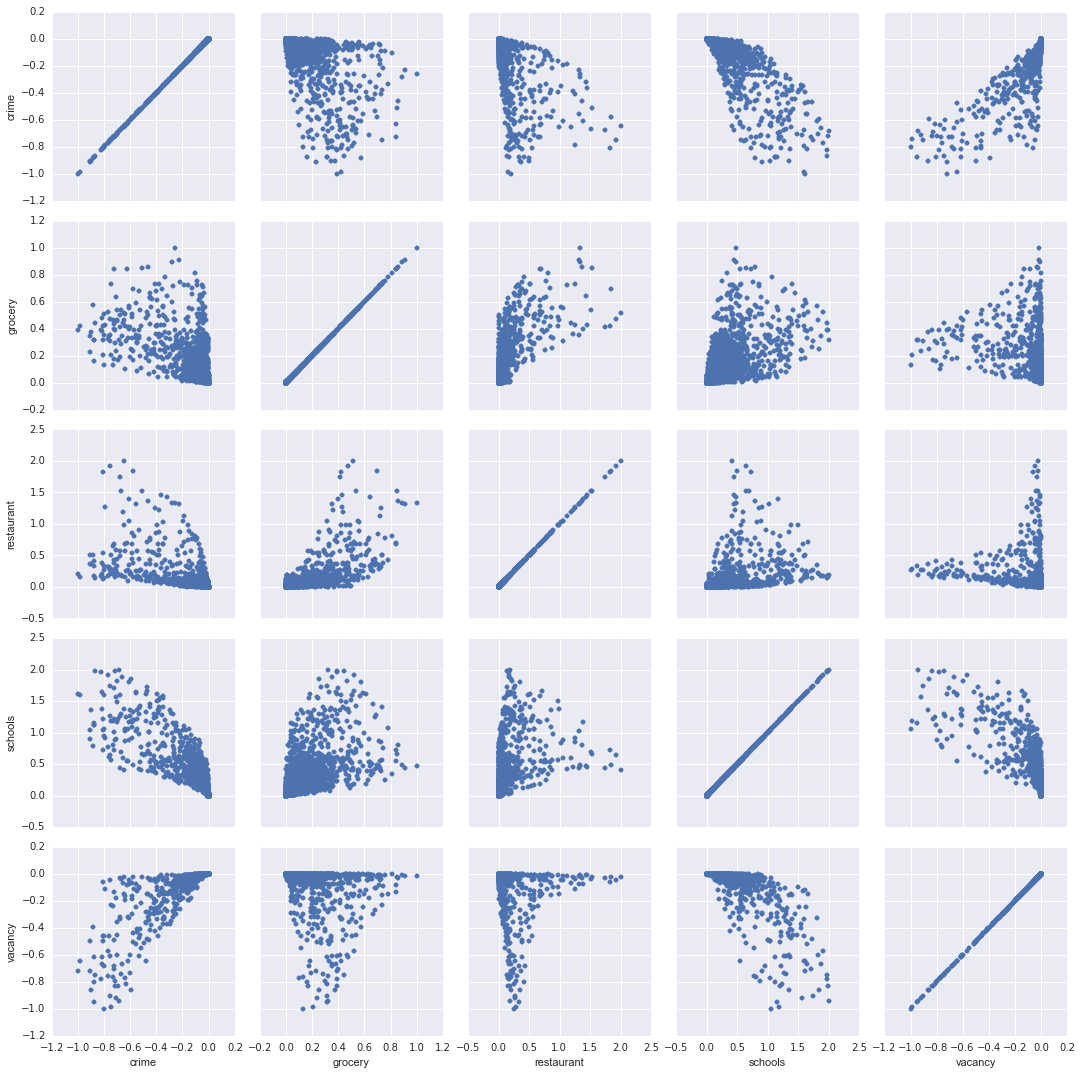

In [8]:
g = sns.PairGrid(map_df)
g.map(plt.scatter)

In [12]:
from sklearn.cluster import KMeans
def plot_KDE(lons, lats, kernel_density, mapname):
    plt.figure(figsize=(6, 5))
    plt.imshow(
        np.rot90(np.reshape(kernel_density, (len(lons), len(lats))).T),
        cmap=plt.cm.RdBu,
        extent=[min(lons), max(lons), min(lats), max(lats)]
    )
    plt.axis([min(lons), max(lons), min(lats), max(lats)])
    plt.title(mapname)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Kernel Density (arb.)')

In [10]:
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more

In [13]:
clusters = 7
model = KMeans(n_clusters=clusters)
model.fit(map_df)
neighborhoods = model.predict(map_df)
#plt.hist(neighborhoods, bins=clusters)
plot_KDE(x, y, neighborhoods, 'clusters')

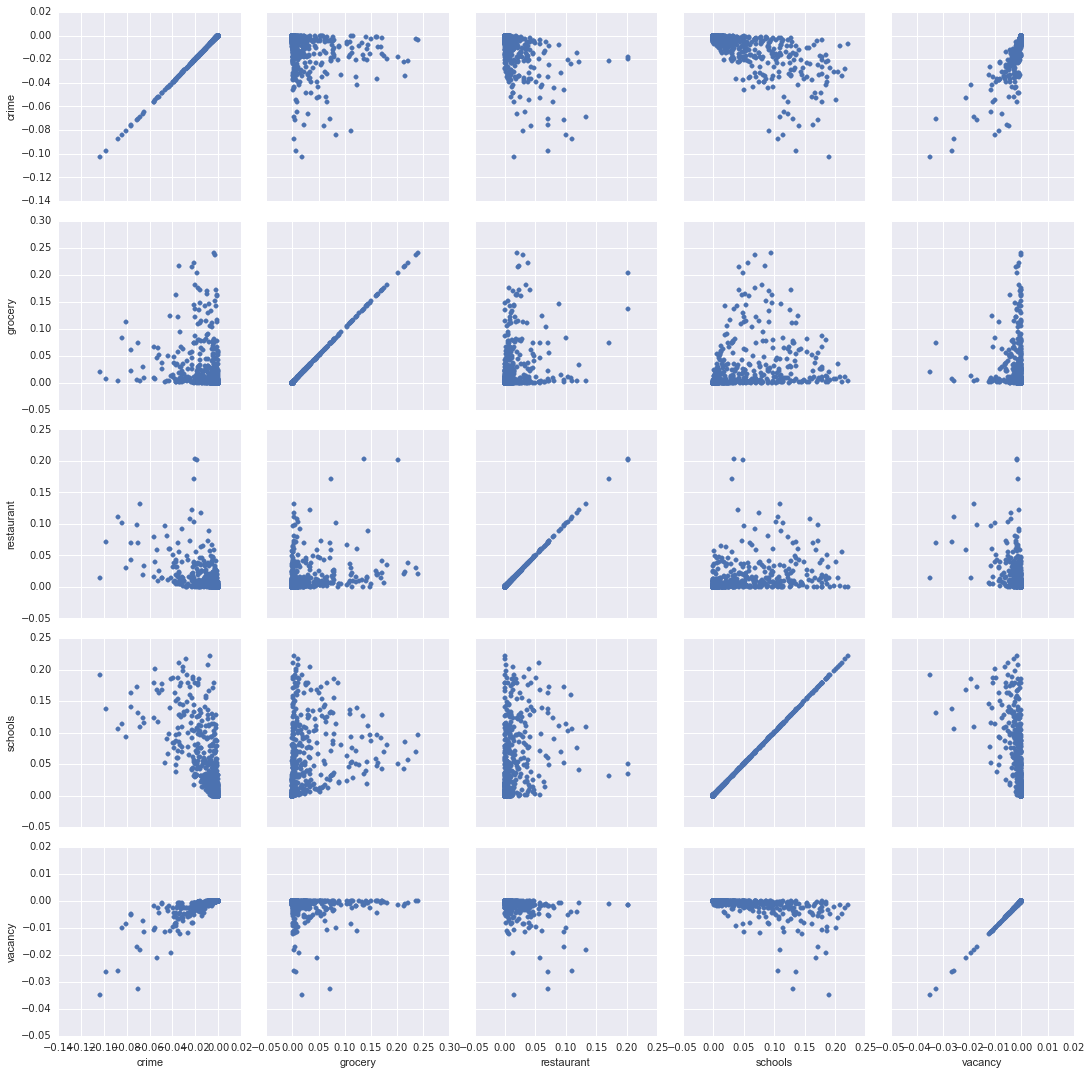

In [61]:
g = sns.PairGrid(map_df[neighborhoods == 3])
g.map(plt.scatter)

In [55]:
neighborhoods == 0

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)